In [31]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")
sys.path.append("/home/rossidaniel/Dropbox")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python")

In [32]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from sqlalchemy import create_engine
from mail import send_mail
from Test_BP_G import euristic

In [38]:
def rw(it):
    return it.realDim().width*it.item.rotation + it.realDim().depth*(1-it.item.rotation)

In [39]:
def rd(it):
    return it.realDim().depth*it.item.rotation + it.realDim().width*(1-it.item.rotation)

In [40]:
def lateral(i,j,items):
    return 0 if(round(items[j].pos.y,6) >= round(items[i].pos.y,6) + round(rd(items[i]))) else 1

In [41]:
def check(i,j,items):
    if round(items[j].pos.y,6) + round(rd(items[j]),6) <= round(items[i].pos.y,6):
        return 0,0,0
    if(round(items[j].pos.x,6) + round(rd(items[j]),6)):
        n= lateral(i,j,items)
        return n,0,0
    if(round(items[j].pos.x,6) >= round(items[i].pos.x,6) + round(rw(items[i]),6)):
        n= lateral(i,j,items)
        return 0,n,0
    
    return 0,0,1

In [42]:
def choose(i, items):
    left = 0
    right = 0
    high = 0
    l = 0
    r = 0
    h = 0
    for j in range(len(items)):
        if (items[i].item.order_id < items[j].item.order_id and i != j):
            #print ""
            #print 'i_d:',items[i].item.order_id ,' j_d:', items[j].item.order_id ,' i:', i ,' j:', j
            l,r,h = check(i,j,items)

            if l == True: print j,"a sinistra di",i
            if r == True: print j,"a destra di",i
            if h == True: print j,"al di sopra di",i

            left += l
            right += r
            high += h
    #print left,right,high
    if left >0 and right > 0 and high > 0: print i; return True
    return False

In [43]:
def isfeasibleorder(solution):
    items =solution.getAnchors(0)
    for i in range(len(items)):
        if choose(i,items) == True: return True
    return False

In [7]:
def tc_sfida():
    item_list = []
    bin_list = []

    bin_list.append(BP.Bin(2.70, 13.5, 2.45))
    bin_list.append(BP.Bin(0, 0, 0))

    n_items =random.randint(3,7)

    for i in range(10):
        w=random.uniform(0.5,1)
        d=random.uniform(0.5,1)
        h=random.uniform(0.5,1.5)
        item = BP.Item(i,h,d,w)
        item.stackable = random.randint(0,0)
        item.order_id = random.randint(0,3)
        item.weight = 4
        item_list.append(item)

    return item_list, bin_list

In [8]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
        
    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        M=sum([max(w[i],d[i]) for i in range(n)])

        W =self.bp.bins[0].width
        D =solver.NumVar(0,M,"D")
        H =self.bp.bins[0].height
        
        Mw=W+M
        Md=self.bp.bins[0].depth+M
        Mz=H+max(h)
                
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]


        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] >= 1)                           #(1)
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])         #(2)
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])         #(3)
            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)                                        #(4)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)                                        #(5)

        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        t=time.time()
        solver.Solve()
        t =time.time()-t

        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(round(x[i].solution_value(),3),round(y[i].solution_value(),3),0),rt,False)
        return s,t,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [9]:
n_items = []
Avg_w = []
Avg_d = []
Avg_a = []
Time = []
eu_obj = []
mod_obj = []
Avg_wd = []
square_index = []

In [24]:
#for i in range(1):
#    if (i % 25 == 0): print i
items,bins=tc_sfida()
model = model_bin_packing(items,bins)
s,t,w,d,h,n=model.buildModel()
s.computeObj()
mod_obj.append(s.obj)
eu_obj.append(euristic(items,bins))
Time.append(round(t,3))
n_items.append(n)

In [25]:
min([s.checkStable(i,0) for i in s.getAnchors(0)])

True

In [44]:
isfeasibleorder(s)

TypeError: rd() takes exactly 1 argument (2 given)

In [27]:
print s


BIN: (w,d,h) = (2.45,13.5,2.7)
[Anchors]:
Point: (x,y,z) = (0.0,0.0,0.0), Item: [0 (1)] (w,d,h) = (0.930672513634,0.948306991809,0.851035774991), weight = 4.0
Point: (x,y,z) = (1.921,1.744,0.0), Item: [1 (1)] (w,d,h) = (0.873345327732,0.529483403958,1.37906123076), weight = 4.0 [R] 
Point: (x,y,z) = (1.831,0.512,0.0), Item: [2 (1)] (w,d,h) = (0.619262460347,0.701836461792,0.772131743326), weight = 4.0
Point: (x,y,z) = (0.0,1.739,0.0), Item: [3 (2)] (w,d,h) = (0.964760390628,0.873674870466,1.05195070591), weight = 4.0
Point: (x,y,z) = (1.618,0.0,0.0), Item: [4 (1)] (w,d,h) = (0.831784517305,0.511820019465,1.10820699344), weight = 4.0
Point: (x,y,z) = (0.972,1.764,0.0), Item: [5 (3)] (w,d,h) = (0.837888326409,0.948536063,1.37219276283), weight = 4.0 [R] 
Point: (x,y,z) = (0.0,0.948,0.0), Item: [6 (2)] (w,d,h) = (0.95136328626,0.790778177858,1.09532203339), weight = 4.0
Point: (x,y,z) = (0.968,0.883,0.0), Item: [7 (3)] (w,d,h) = (0.86229357013,0.88014316151,1.46600325267), weight = 4.0
P

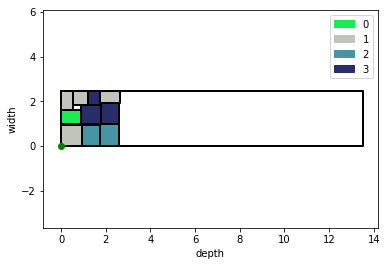

In [28]:
BP_plot.plotSolution(s)

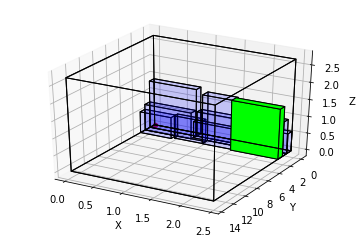

In [15]:
BP_plot.plot3DSolution(s,0,7)

In [16]:
dimensioni =pd.DataFrame({'n_items': n_items, 'Eu obj': eu_obj,'Mod obj': mod_obj, 'Time': Time})

In [17]:
dimensioni.to_excel('result'+1+'.xlsx', encoding='utf8')
dimensioni.to_latex('result.tex', encoding='utf8')
dimensioni.to_csv('result.csv', encoding='utf8')

In [18]:
dimensioni

,Eu obj,Mod obj,Time,n_items
0,2.638998,2.399548,310.362,10


In [19]:
#send_mail()